# Projeto 3#
#### Antonio Fonseca, Daniel Pucciariello e José Bechara.####

## Tema:##
*Prever se um projeto do kickstarter irá ser bem sucedido ou não.*

Técnica: Classificador.

Objetivo secundário:

*Tentar estimar o valor a ser recebido baseado nas características de um projeto do kickstarter.*

Técnica: Regressão.

https://www.kaggle.com/kemical/kickstarter-projects


In [2]:
%matplotlib notebook
%reset -f


import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from datetime import datetime

%matplotlib inline

In [3]:
def dummify(data, column_name):
    """
        Converte a coluna column_name em dummies / one-hot e as adiciona ao dataframe
        retorna uma copia do  df original *sem* a coluna que foi dummified
    """
    df = data.copy()
    # Nota: se você for um econometrista, pode se interessar por usar a opção dropFirst = True na get_dummies
    df2 = pd.concat([df.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

def calculo_dias(date1,date2):
    """
        Função que calculo a quantidade de dias que um projeto ficou ativo.
    """
    date_format = "%Y-%m-%d %H:%M:%S"
    a = datetime.strptime(date1, date_format)
    b = datetime.strptime(date2, date_format)
    delta= a-b
    return delta.days

## Leitura dos dataframes:

In [4]:
data = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])


In [5]:
data = data[data.state != "live"]

data_boolean = data.replace("canceled", "failed").replace("undefined", "failed").replace("suspended", "failed")
#criação de dataframe cujos estados dos projetos eram "failed" ou "successful"

In [6]:
data.main_category.value_counts()
#Categorias dos projetos

Film & Video    63253
Music           51637
Publishing      39575
Games           34944
Technology      32192
Design          29765
Art             27959
Food            24418
Fashion         22566
Theater         10872
Comics          10743
Photography     10731
Crafts           8733
Journalism       4724
Dance            3750
Name: main_category, dtype: int64

### Dataframe cru:

In [7]:
data.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


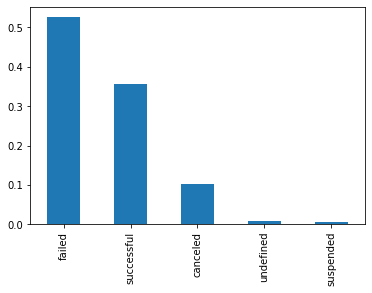

In [8]:
data.state.value_counts(True).plot.bar();
#distribuição dos estados dos projetos.

In [9]:
data.state.value_counts(True)*100

failed        52.604147
successful    35.639676
canceled      10.317351
undefined      0.947688
suspended      0.491138
Name: state, dtype: float64

### Categorias:

In [10]:
print("Tamanho do dataframe:")
len(data)

Tamanho do dataframe:


375862

In [11]:
data.category = data.category.astype('category')
data.main_category = data.main_category.astype('category')
data.state = data.state.astype('category')
data.country = data.country.astype('category')

### Porcentagem de sucesso nos projetos:

In [12]:
failed=data_boolean.state.value_counts()[0]
sucessful=data_boolean.state.value_counts()[1]
print("Número de projetos que falharam:", failed)
print("Número de projetos bem sucedidos:", sucessful)
print("Porcentagem de sucesso:", 100*sucessful/(failed + sucessful), "%")

Número de projetos que falharam: 241906
Número de projetos bem sucedidos: 133956
Porcentagem de sucesso: 35.639676264160784 %


### Representação gráfica desses dados:

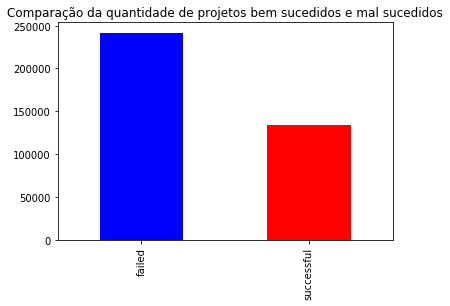

In [13]:
data_boolean.state.value_counts().plot(kind='bar', color=('blue', 'red'), legend=False)
plt.title("Comparação da quantidade de projetos bem sucedidos e mal sucedidos")
plt.show();

### "Dummyficando" as variáveis qualitativas:

In [14]:
data_dummified = dummify(data, "main_category")
data_dummified = dummify(data_dummified, "state")

data_dummified.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real',
       'usd_goal_real', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'state_canceled', 'state_failed',
       'state_successful', 'state_suspended', 'state_undefined'],
      dtype='object')

In [15]:
#criação de um dataframe com as variaveis quantitativas (incluindo as provenientes de dummyficação)
quantitativas = data_dummified.loc[:,['goal', 'state_successful', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater' ]]
quantitativas.head(5)

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Calculando o tempo de duração da campanha:

In [16]:
#criação de uma lista com os valores de tempo de campanha em dias.
delta_t =[]
for e,i in zip(data.deadline, data.launched):
    e = str(e)
    i = str(i)
    a = calculo_dias(e,i)
    delta_t.append(a)

In [17]:
#criação de um dataframe semelhante ao criado anteriormente, porém com o delta_t dos projetos.
data_delta_t=quantitativas
data_delta_t["deltat (days)"]=delta_t
data_delta_t.head()

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,deltat (days)
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,58
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,59
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,44
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,29
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,55


In [18]:
y = quantitativas.state_successful == 1 # Selecionando apenas as campanhas que obtiveram sucesso para criar uma lista com valores booleanos (True ou False)

# Regressão Logística:

### Criação de diversos dataframes para serem utilizados pelo modelo e posteriormente testarem sua acurácia.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_delta_t, y, test_size=0.1, random_state=112)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((338275, 18), (338275,), (37587, 18), (37587,))

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=200)

### Verificando se a proporção de sucessos e falhas no conjunto de treinamento é similar à proporção dos mesmos no conjunto de testes.

In [22]:
conta_treinamento = pd.Series(y_train).value_counts()
conta_treinamento

False    217539
True     120736
Name: state_successful, dtype: int64

In [23]:
conta_teste = pd.Series(y_test).value_counts()
conta_teste

False    24367
True     13220
Name: state_successful, dtype: int64

In [24]:
conta_treinamento[True] / conta_treinamento[False]

0.5550085272066159

In [25]:
conta_teste[True] / conta_teste[False]

0.5425370377970206

In [26]:
X_train=X_train.drop(columns=['state_successful']) # removendo coluna de estado do dataframe de treinamento

In [27]:
X_test=X_test.drop(columns=['state_successful'])# removendo coluna de estado do dataframe de teste 

In [28]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
y_pred = model.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6482826509165402


# Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rdm_forest = RandomForestClassifier(n_estimators=10, random_state=112)
rdm_forest = rdm_forest.fit(X_train,y_train)
rdm_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=112,
                       verbose=0, warm_start=False)

In [32]:
y_pred = rdm_forest.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6596961715486738


# Regressão Linear:

In [33]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [34]:
def rms(y, y_pred):
    '''
    Retorna o RMS
    
    y --> valores reais
    y_pred --> valores previstos
    '''
    return (sum((y-y_pred)**2)*1/len(y))**0.5

In [35]:
def acuracia(limite, y_pred, y_test):
    total = 0
    acertos = 0
    erros = 0
    lista = []
    for e,i in zip(y_pred, y_test):
        total+=1
        maximo = i + limite*i 
        minimo = i - limite*i
        if e<=maximo and e>=minimo:
            lista.append(True)
            acertos +=1
        else:
            lista.append(False)
            erros+=1
    acc = "Acurácia=",acertos/total
    erro = "Erro=",erros/total
    
    return acc, erro

In [36]:
data_dummified.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real',
       'usd_goal_real', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'state_canceled', 'state_failed',
       'state_successful', 'state_suspended', 'state_undefined'],
      dtype='object')

In [37]:
data_regressao_pledge = data_dummified.loc[:,['goal', 'state_successful', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', "usd_pledged_real", "usd_goal_real"]]
data_regressao_pledge.head()

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,usd_pledged_real,usd_goal_real
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,1533.95
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2421.0,30000.00
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,220.0,45000.00
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,5000.00
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1283.0,19500.00


In [38]:
y2 = data_regressao_pledge.usd_pledged_real
data_regressao_pledge["delta t"]=delta_t
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_regressao_pledge, y2, test_size=0.1, random_state=112)

In [39]:
X_test2=X_test2.drop(columns=['usd_pledged_real', "state_successful"]) # removendo coluna de dinheiro do dataframe de treinamento

In [40]:
X_train2=X_train2.drop(columns=['usd_pledged_real', "state_successful"]) # removendo coluna de dinheiro do dataframe de treinamento

In [41]:
model = regress(X_train2,y_train2)
model.summary() 

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     151.6
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:06:10   Log-Likelihood:            -4.3372e+06
No. Observations:              338275   AIC:                         8.674e+06
Df Residuals:                  338257   BIC:                         8.675e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       7197.0784    211.313     34.059      0.000    6782.911    7611.246
goal                          -0.0003      0.000     -0.697      0.486      -0.001       0.001
main_category_Art          -4032.3782    564.742     -7.140      0.000   -5139.256   -2925.500
main_category_Comics        -480.4577    872.516     -0.551      0.582   -2190.563    1229.648
main_category_Crafts       -5641.7619    964.362     -5.850      0.000   -7531.884   -3751.640
main_category_Dance        -3710.9949   1455.416     -2.550      0.011   -6563.569    -858.421
main_category_Design        1.694e+04    548.701     30.872      0.000    1.59e+04     1.8e+04
main_category_Fashion      -1409.1162    620.868     -2.270      0.023   -2625.999    -192.233
main_category_Film & Video -1083.2606    404.246     -2.680      0.007   -1875.571    -290.950
main_category_Food         -2262.2413    600.847     -3.765      0.000   -3439.885   -1084.598
main_category_Games         1.384e+04    512.857     26.994      0.000    1.28e+04    1.48e+04
main_category_Journalism   -4696.0109   1306.356     -3.595      0.000   -7256.431   -2135.590
main_category_Music        -3367.9611    436.701     -7.712      0.000   -4223.883   -2512.039
main_category_Photography  -3670.9862    875.459     -4.193      0.000   -5386.861   -1955.111
main_category_Publishing   -3926.8342    487.456     -8.056      0.000   -4882.235   -2971.434
main_category_Technology    1.389e+04    530.330     26.187      0.000    1.28e+04    1.49e+04
main_category_Theater      -3192.3330    870.491     -3.667      0.000   -4898.470   -1486.195
usd_goal_real                  0.0007      0.000      1.631      0.103      -0.000       0.001
delta t                        1.0523      2.213      0.476      0.634      -3.285       5.389
==============================================================================
Omnibus:                  1266803.741   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    2160412393104.332
Skew:                          83.084   Prob(JB):                         0.00
Kurtosis:                   12382.408   Cond. No.                     2.97e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.47e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [42]:
x_vc=(sm.add_constant(X_test2))
y_pred2=model.predict(x_vc) 
erro = rms(y_test2,y_pred2)
print("RMS =",erro)

RMS = 102563.9825659787


In [43]:
acc = acuracia(0.35, y_pred2, y_test2)
acc

(('Acurácia=', 0.09894378375502168), ('Erro=', 0.9010562162449783))

## Random Forest Regressor

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [45]:
regr_rd = RandomForestRegressor(max_depth=4, random_state=113, n_estimators=100) 
regr_rd.fit(X_train2, y_train2)  

y_pred3=regr_rd.predict(X_test2)

In [46]:
from sklearn.metrics import r2_score

r2_score(y_test2, y_pred3, multioutput="variance_weighted")

0.031000437373576162

In [47]:
#comparador de RMS sklearn metrics

In [48]:
acc = acuracia(0.35, y_pred3, y_test2)
acc

(('Acurácia=', 0.15893793066751802), ('Erro=', 0.841062069332482))